- (3.1) Analysis of DP, MC on Frozen Lake (2 Points)
- (4.1) Implement TD(0) (Policy Evaluation) (3 Points)
- (4.2) Implement SARSA (Policy Improvement) (5 Points)
- (4.3) Implement Q-Learning (Policy Improvement) (5 Points)
- (4.4) Implement Expected-SARSA (Policy Improvement) (5 Points)
- (4.5) Implement Double-Q Learning (De-biased Policy Improvement) (5 Points)

**Do not forget to run all the code cells, before saving and submitting the assignment!**

# Part 1: Frozen Lake, Dynamic Programming

<div class="alert alert-info">
The following description is adapted from <a href="https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py">the environment description</a>:

<pre><code>
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        
        SFFFFFFF
        FFFFFFFF
        FFFHFFFF
        FFFFFHFF
        FFFHFFFF
        FHHFFFHF
        FHFFHFHF
        FFFHFFFG
        
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
</code></pre>

You will now use this environment to implement prediction and control algorithms.


<h2>Preliminaries</h2>

What follows are the imports, the generation of the environment and some helper functions. You have to run this cell first, before starting to implement and run your algorithms.

In [1]:
!pip3 install gym

In [2]:
# the next line is to automatically reload changed, external modules
from pprint import pprint

# the function pprint is a pretty printer for more
# complex datastructures, such as dict's, sets, lists, etc...
# this might be helpful for debugging, etc...

complex_data = dict(
    some_key=[
        (0, 1, 2, dict(a=0, b=1)),
        (2, 3, 4, dict(c=2, d=2)),
        (5, 6, 7, dict(e=3, f=3))
    ],
    some_other_key=dict(
        d='e', f='g'
    )
)

print('this does not look so good:')
print(complex_data)
print('\n\n' + '-' * 40)
print('this is much more readable:')
pprint(complex_data)

this does not look so good:
{'some_key': [(0, 1, 2, {'a': 0, 'b': 1}), (2, 3, 4, {'c': 2, 'd': 2}), (5, 6, 7, {'e': 3, 'f': 3})], 'some_other_key': {'d': 'e', 'f': 'g'}}


----------------------------------------
this is much more readable:
{'some_key': [(0, 1, 2, {'a': 0, 'b': 1}),
              (2, 3, 4, {'c': 2, 'd': 2}),
              (5, 6, 7, {'e': 3, 'f': 3})],
 'some_other_key': {'d': 'e', 'f': 'g'}}


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import gym
from copy import deepcopy

np.set_printoptions(precision=4, suppress=True, threshold=200)


def gridworld_print_deterministic_policy(env, policy):
    """
    Generate a deterministic policy from a stochastic policy by taking
    the argmax action for every state. Then make it human-readable via 
    a given move dictionary
    
    Args:
        env: the openai gym environment
        policy: a policy given as np.array
    
    Returns:
        a human readable policy as np.array
    """
    moves = ['L', 'D', 'R', 'U']
    deterministic_policy = np.array([np.argmax(policy[s]) for s in range(env.observation_space.n)])
    human_readable_policy = np.array([moves[s] for s in deterministic_policy])
    
    desc = env.desc.reshape(env.observation_space.n)
    for s in range(env.observation_space.n):
        if desc[s] in (b'H', b'G'):
            human_readable_policy[s] = desc[s]
            
    print(human_readable_policy.reshape((env.nrow, env.ncol)))


# this is a helper function that turns a V represented as a dict into an array
def dict_to_array(env, d):
    V = np.zeros(env.observation_space.n)
    for state, value in d.items():
        V[state] = value
    return V    


def gridworld_print_value_function(env, V_dict):
    V = dict_to_array(env, V_dict)
    # for gridworlds, we reshape this array to reflect
    # its 'spatial' properties - so the state value function
    # has the same shape as the gridworld
    print(V.reshape(env.nrow, env.ncol))


def gridworld_plot_policy(env, policy):
    """
    This is going to generate a quiver plot to visualize the policy graphically.
    It is useful to see all the probabilities assigned to the four possible actions
    in each state
    """
    fig, ax = plt.subplots()
    xs = np.arange(env.ncol)
    ys = np.arange(env.nrow)
    xx, yy = np.meshgrid(xs, ys)
    
    direction = [
        np.array((-1, 0)),  # left
        np.array((0, -1)),  # down
        np.array((+1, 0)),  # right
        np.array((0, +1)),  # up
    ]
    
    # we need a quiver for each of the four action
    quivers = list()
    for a in range(env.action_space.n):
        quivers.append(list())

    # we parse the textual description of the lake
    desc = env.desc.reshape(env.observation_space.n)
    for s in range(env.observation_space.n):
        if desc[s] in (b'H', b'G'):
            for a in range(4):
                quivers[a].append((0., 0.))
        else:
            for a in range(4):
                quivers[a].append(direction[a] * policy[s][a])
    
    # plot each quiver
    for quiver in quivers:
        q = np.array(quiver)
        ax.quiver(xx, yy, q[:, 0], q[:, 1], units='xy', scale=1.5)
    
    # set axis limits / ticks / etc... so we have a nice grid overlay
    ax.set_xlim((xs.min() - 0.5, xs.max() + 0.5))
    ax.set_ylim((ys.max() + 0.5, ys.min() - 0.5))  # y axis is flipped, so it corresponds to what imshow shows

    ax.set_xticks(xs)
    ax.set_yticks(ys)
    
    # major ticks
    sx = env.ncol
    sy = env.nrow
    ax.set_xticks(np.arange(0, sx, 1))
    ax.set_yticks(np.arange(0, sy, 1))

    # minor ticks
    ax.set_xticks(np.arange(-.5, sx, 1), minor=True)
    ax.set_yticks(np.arange(-.5, sy, 1), minor=True)

    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)

    ax.set_aspect(1)
    plt.show()


def gridworld_plot_value_function(env, V_dict, vmin=None, vmax=None):
    """
    This is going to show the value function 'V' as an image
    """
    V = dict_to_array(env, V_dict)
    if vmin is None:
        vmin = V.min()
    if vmax is None:
        vmax = V.max()

    mask = np.full_like(V, False, dtype=np.bool)
    # mark the terminal states as having 'no value'
    # to do that, we parse the textual description of the gridworld
    ux = []
    uy = []
    desc = env.desc.reshape(env.observation_space.n)
    for s in range(env.observation_space.n):
        if desc[s] in (b'H', b'G'):
            y, x = divmod(s, env.ncol)
            ux.append(x)
            uy.append(y)
            mask[s] = True
    
    # mask out all terminal states
    masked = np.ma.masked_where(mask, V)
        
    fig, ax = plt.subplots()
    im = ax.imshow(
        masked.reshape((env.nrow,env.ncol)),
        cmap='magma',
        vmin=vmin,
        vmax=vmax,
        aspect=1
    )
   
    ax.scatter(ux, uy, marker='x', color='r')
    
    xs = np.arange(env.ncol)
    ys = np.arange(env.nrow)
    
    # set axis limits / ticks / etc... so we have a nice grid overlay
    ax.set_xlim((xs.min() - 0.5, xs.max() + 0.5))
    ax.set_ylim((ys.max() + 0.5, ys.min() - 0.5))  # y axis is flipped, so it corresponds to what imshow shows

    ax.set_xticks(xs)
    ax.set_yticks(ys)
    
    # major ticks
    sx = env.ncol
    sy = env.nrow
    ax.set_xticks(np.arange(0, sx, 1))
    ax.set_yticks(np.arange(0, sy, 1))

    # minor ticks
    ax.set_xticks(np.arange(-.5, sx, 1), minor=True)
    ax.set_yticks(np.arange(-.5, sy, 1), minor=True)

    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)
    
    plt.colorbar(im)
    plt.show()

## Quickstart

Here we give you a few hints on how to use the openai gym, what the data formats look like, etc.

### Loading the Environment and Moving Around

In [4]:
# load the environment
lake_env = gym.make('FrozenLake8x8-v0')
# reset it (set it back to its inital state (not strictly necessary here...))
lake_env.reset()
# let's start by looking at our environment
lake_env.render()

# we can try to move around:
print('-' * 20)
result = lake_env.step(1) # let's try to move downwards
print(result)
# the result will look something like this:
# (8, 0.0, False, {'prob': 0.3333333333333333})
# which means that we are now in state 8, we got 0 reward for our last step,
# it is not a goal state and that the probability that we end up in this new state,
# given what our previous state and the action was, is 0.33 (so it is very, very slippery)
# we can have another look at our environment (chances are that the agent moved away from the inital square)
lake_env.render()

# let's do this again ...
print('-' * 20)
result = lake_env.step(2) # let's try to go right
print(result)
lake_env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
--------------------
(0, 0.0, False, {'prob': 0.3333333333333333})
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
--------------------
(0, 0.0, False, {'prob': 0.3333333333333333})
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


### Accessing Information about the Environment

In [5]:
# we have perfect information about our environment (and you should make use of it in your code...):
print("Shape: ", lake_env.ncol, lake_env.nrow) # we know the shape of our lake
print("Number of States: ", lake_env.observation_space.n) # we can also access the number of states directly
print("Number of Actions: ", lake_env.action_space.n) # we know the number of actions

# the dynamics are given as a dictionary (you can print the full dynamics by uncommenting the next line)
# print "Dynamics: ", env.env.P # and we know the dynamics

print("\nFor example, the dynamics for state 0 look like this:")
pprint(lake_env.P[0])
print("\nAnd if are in state 0 and take action 1, these are the dynamics:")
pprint(lake_env.P[0][1])

# i.e. env.env.P[x][y] gives you for state x and move y a list of possible outcomes.
# e.g. if we take action 1 at state 0, this is the result:
# [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 8, 0.0, False), (0.3333333333333333, 1, 0.0, False)]
# which means that with a probability of 0.33 we end up at state 0, get 0.0 reward,
# and it is a non-terminal state, etc.

# this means we can use dynamic programming to compute an optimal policy

Shape:  8 8
Number of States:  64
Number of Actions:  4

For example, the dynamics for state 0 look like this:
{0: [(0.3333333333333333, 0, 0.0, False),
     (0.3333333333333333, 0, 0.0, False),
     (0.3333333333333333, 8, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
     (0.3333333333333333, 8, 0.0, False),
     (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 8, 0.0, False),
     (0.3333333333333333, 1, 0.0, False),
     (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
     (0.3333333333333333, 0, 0.0, False),
     (0.3333333333333333, 0, 0.0, False)]}

And if are in state 0 and take action 1, these are the dynamics:
[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 8, 0.0, False),
 (0.3333333333333333, 1, 0.0, False)]


### Storing and visualizing Policies and Value Functions


A sample (first 10x4 state-action pairs) from the policy:

[(0, array([0.25, 0.25, 0.25, 0.25])),
 (1, array([0.25, 0.25, 0.25, 0.25])),
 (2, array([0.25, 0.25, 0.25, 0.25])),
 (3, array([0.25, 0.25, 0.25, 0.25])),
 (4, array([0.25, 0.25, 0.25, 0.25])),
 (5, array([0.25, 0.25, 0.25, 0.25])),
 (6, array([0.25, 0.25, 0.25, 0.25])),
 (7, array([0.25, 0.25, 0.25, 0.25])),
 (8, array([0.25, 0.25, 0.25, 0.25])),
 (9, array([0.25, 0.25, 0.25, 0.25]))]

The random policy in full (the dots are where goals and holes are):



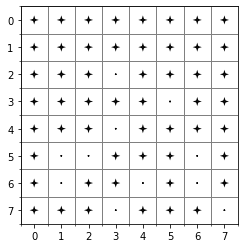


An initial, all-zero value function:

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

We can also plot the all-zero value function:



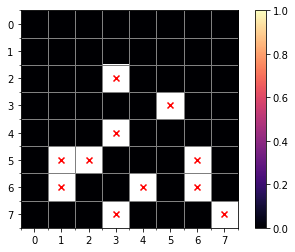

In [6]:
# how do we store a policy?
# we simply use a dictionary that maps states to actionprobabilities

# let's create a function that returns a random walk policy
def gridworld_random_policy(env):
    policy = dict()
    for state in range(env.observation_space.n):
        # all actions have equal probability
        policy[state] = np.ones(env.action_space.n) / env.action_space.n
    return policy

policy = gridworld_random_policy(lake_env)

print("\nA sample (first 10x4 state-action pairs) from the policy:\n")
pprint(list(policy.items())[0:10])

print("\nThe random policy in full (the dots are where goals and holes are):\n")
gridworld_plot_policy(lake_env, policy)

# and the value function?
# we will use a dictionary again
def gridworld_initial_value_function(env):
    return {s: 0 for s in range(env.observation_space.n)}

print('\nAn initial, all-zero value function:\n')
V = gridworld_initial_value_function(lake_env)
gridworld_print_value_function(lake_env, V)

print("\nWe can also plot the all-zero value function:\n")
gridworld_plot_value_function(lake_env, V, 0, 1)

## Policy Evaluation with Dynamic Programming

This is the first policy evaluation algorithm we have learned about. It is the in-place version, using only one current estimate $V$.

In [7]:
def dp_policy_evaluation(env, policy, V_init, gamma=0.999, theta=1e-6):
    """
    Policy Evaluation via Dynamic Programming
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        V_init: the initial value function
        gamma: discount factor gamma
        theta: the stopping criterion
    
    Returns:
        the value function for a given policy
    """
    V = deepcopy(V_init)
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = 0
            for a, pa in enumerate(policy[s]):
                for ps, sprime, r, _ in env.P[s][a]:
                    v += pa * ps * (r + gamma * V[sprime])
    
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
            
        if delta < theta:
            break
        
    return V

### Run DP Policy Evaluation 
Okay, let's now run the implemented algorithm on the fishlake environment.


The random policy:



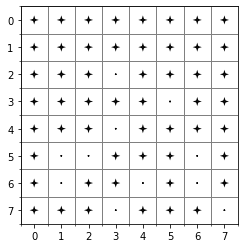


The Value Function of our Policy:

[[0.0018 0.002  0.0027 0.0039 0.0063 0.0095 0.013  0.0155]
 [0.0015 0.0017 0.002  0.0029 0.0055 0.0091 0.0142 0.018 ]
 [0.0011 0.0011 0.001  0.     0.0038 0.0074 0.0166 0.0245]
 [0.0008 0.0007 0.0007 0.0008 0.0023 0.     0.0203 0.0389]
 [0.0004 0.0004 0.0003 0.     0.0048 0.0115 0.026  0.0721]
 [0.0002 0.     0.     0.0014 0.0054 0.0152 0.     0.1517]
 [0.0001 0.     0.0001 0.0004 0.     0.0441 0.     0.3837]
 [0.0001 0.     0.     0.     0.0537 0.1614 0.3869 0.    ]]

Let's plot this as well:



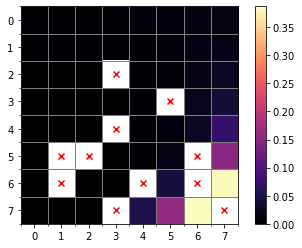

In [8]:
# let's create a uniformly random policy
policy = gridworld_random_policy(lake_env)

print("\nThe random policy:\n")
gridworld_plot_policy(lake_env, policy)

# we need an initial value function
V_init = gridworld_initial_value_function(lake_env)

# and now let's see how good our policy is
V = dp_policy_evaluation(lake_env, policy, V_init, gamma=0.999)

# print the value function
print("\nThe Value Function of our Policy:\n")
gridworld_print_value_function(lake_env, V)

print("\nLet's plot this as well:\n")
gridworld_plot_value_function(lake_env, V)

## Policy Improvement with Dynamic Programming

Let's try and improve a given policy! We will use this algorithm later on within the policy iteration algorithm to compute the optimal policy.

In [9]:
def dp_policy_improvement(env, policy, V, gamma=0.999, theta=1e-6):
    """
    Policy Improvement
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        V: the value function of the policy
        gamma: the discount factor
        theta: the stopping criterion
    
    Returns:
        a tuple (policy, bool) consisting of
        the improved policy (a numpy array)
        and a boolean, indicating it the policy is stable
        meaning the improved policy is the same as the
        input policy
    """
    policy_stable = True

    for s in range(env.observation_space.n):
        chosen_a = np.argmax(policy[s])

        action_values = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, _ in env.P[s][a]:
                action_values[a] += prob * (reward + gamma * V[next_state])
        best_a = np.argmax(action_values)

        if chosen_a != best_a:
            policy_stable = False
            policy[s] = np.eye(env.action_space.n)[best_a]
        else:
            policy[s] = np.eye(env.action_space.n)[chosen_a]

        # a note on what 'np.eye(d)[i]' does:
        # np.eye(d) returns an identity matrix of size (d, d)
        # [i] selects the i-th row of this matrix, which
        # is exactly the vector [0, ... 1, ... 0] with the '1' at
        # the i-th position. incredibly inefficient, but practical.
    return policy, policy_stable

## Policy Iteration

This one is easy, as we have a function that evaluates, and a function that improves a policy.

In [10]:
def dp_policy_iteration(env, policy, V_init, gamma=0.999, theta=1e-6):
    """
    Policy Iteration
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        V_init: an inital value function
    
    Returns:
        a tuple (policy, V) consisting of
        the optimal policy
        and the respective value function
    """
    V = deepcopy(V_init)
    
    while True:
        V = dp_policy_evaluation(env, policy, V, gamma, theta)
        policy, stable = dp_policy_improvement(env, policy, V, gamma, theta)
        
        if stable:
            return policy, V

### Run DP Policy Iteration

Next, let's improve a random policy and compute the optimal policy by using  policy iteration.


Deterministic policy computed via the policy iteration algorithm:

[['U' 'R' 'R' 'R' 'R' 'R' 'R' 'R']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'R']
 ['L' 'U' 'L' 'H' 'R' 'U' 'R' 'R']
 ['L' 'L' 'L' 'D' 'L' 'H' 'R' 'R']
 ['L' 'U' 'L' 'H' 'R' 'D' 'U' 'R']
 ['L' 'H' 'H' 'D' 'U' 'L' 'H' 'R']
 ['L' 'H' 'D' 'L' 'H' 'L' 'H' 'R']
 ['L' 'D' 'L' 'H' 'D' 'R' 'D' 'G']]

and the respective value function:

[[0.8926 0.8953 0.8993 0.9039 0.9088 0.9138 0.9186 0.9224]
 [0.892  0.894  0.8974 0.9017 0.9065 0.9117 0.9176 0.9252]
 [0.8766 0.8623 0.8189 0.     0.7777 0.8653 0.909  0.9307]
 [0.8639 0.8115 0.6993 0.4206 0.5637 0.     0.8816 0.9391]
 [0.8537 0.7109 0.4696 0.     0.4946 0.5684 0.7992 0.9502]
 [0.8461 0.     0.     0.1527 0.3531 0.413  0.     0.9642]
 [0.8411 0.     0.1642 0.1055 0.     0.3188 0.     0.9811]
 [0.8385 0.6121 0.3876 0.     0.2718 0.5443 0.7715 0.    ]]


The same information, graphically represented:



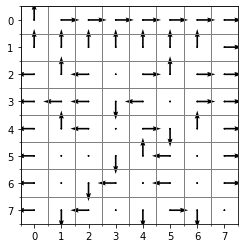

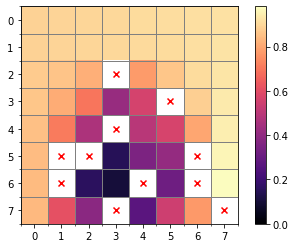

In [11]:
# let's create a uniformly random policy
policy = gridworld_random_policy(lake_env)

# and an initial value function
V_init = gridworld_initial_value_function(lake_env)

# and now let's compute an optimal policy via the policy iteration algorithm
policy, V = dp_policy_iteration(lake_env, policy, V_init)

# print the a human-readable version of the optimal policy
print("\nDeterministic policy computed via the policy iteration algorithm:\n")
gridworld_print_deterministic_policy(lake_env, policy)

print("\nand the respective value function:\n")
gridworld_print_value_function(lake_env, V)

print('\n\nThe same information, graphically represented:\n')
gridworld_plot_policy(lake_env, policy)
gridworld_plot_value_function(lake_env, V)

## Value Iteration

We will now find the optimal value function first, and derive an optimal policy by using one-step lookahead search.

In [12]:
def one_step_lookahead(env, s, V, gamma=0.999):
    A = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        # compute the value of taking 'a' if we are in 's'
        for p, sprime, r, _ in env.P[s][a]:
            A[a] += p * (r + gamma * V[sprime])
    return A


def dp_value_iteration(env, V_init, gamma=0.999, theta=1e-6):
    """
    Value Iteration
    
    Args:
        env: the openai gym environment
        V: a value function
        theta: the stopping criterion
        gamma: discount factor gamma
    
    Returns:
        a tuple (policy, V) consisting of
        the optimal policy
        and the respective value function
    """
    
    V = deepcopy(V_init)

    while True:
        delta = 0
        for s in range(env.observation_space.n):
            # this computes the value of all actions
            A = one_step_lookahead(env, s, V, gamma)
            
            # this computes the best value achievable in 's'
            best_action_value = np.max(A)
            
            # how much difference is there to the current estimate?
            delta = max(delta, np.abs(best_action_value - V[s]))
            
            # update the current estimate
            V[s] = best_action_value
        if delta < theta:
            break
    # here, V is a good estimation of the optimal value function
            
    # we can now create a deterministic optimal policy from the optimal value function
    policy = dict()
    for s in range(env.observation_space.n):
        A = one_step_lookahead(env, s, V, gamma)
        optimal_action = np.argmax(A)
        policy[s] = np.zeros(env.action_space.n)
        policy[s][optimal_action] = 1.0
    
    return policy, V

### Run DP Value Iteration

Finally, let's compute the optimal policy by using value iteration. Obviously the result should be very similar to the policy interation algorithm.


Policy computed via the value iteration algorithm:

[['U' 'R' 'R' 'R' 'R' 'R' 'R' 'R']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'R']
 ['L' 'U' 'L' 'H' 'R' 'U' 'R' 'R']
 ['L' 'L' 'L' 'D' 'L' 'H' 'R' 'R']
 ['L' 'U' 'L' 'H' 'R' 'D' 'U' 'R']
 ['L' 'H' 'H' 'D' 'U' 'L' 'H' 'R']
 ['L' 'H' 'D' 'L' 'H' 'L' 'H' 'R']
 ['L' 'D' 'L' 'H' 'D' 'R' 'D' 'G']]

and the respective value function:

[[0.8926 0.8953 0.8993 0.9039 0.9087 0.9138 0.9186 0.9224]
 [0.892  0.894  0.8974 0.9017 0.9065 0.9117 0.9176 0.9252]
 [0.8766 0.8623 0.8188 0.     0.7777 0.8653 0.909  0.9307]
 [0.8638 0.8115 0.6993 0.4206 0.5637 0.     0.8816 0.939 ]
 [0.8537 0.7109 0.4696 0.     0.4946 0.5684 0.7992 0.9502]
 [0.8461 0.     0.     0.1527 0.3531 0.413  0.     0.9642]
 [0.841  0.     0.1642 0.1055 0.     0.3188 0.     0.9811]
 [0.8385 0.6121 0.3876 0.     0.2718 0.5443 0.7715 0.    ]]

The same information, graphically represented:



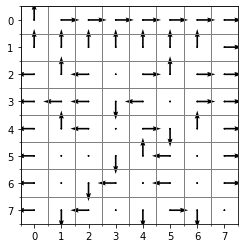

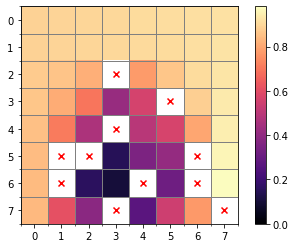

In [13]:
# let's redo the above with value iteration...
V_init = gridworld_initial_value_function(lake_env)
policy, V = dp_value_iteration(lake_env, V_init, gamma=0.999)

print("\nPolicy computed via the value iteration algorithm:\n")
gridworld_print_deterministic_policy(lake_env, policy)

print("\nand the respective value function:\n")
gridworld_print_value_function(lake_env, V)

print("\nThe same information, graphically represented:\n")
gridworld_plot_policy(lake_env, policy)
gridworld_plot_value_function(lake_env, V)

# Part 2: Blackjack - A Model-free Environment, Monte Carlo Methods

Let us now try Monte Carlo methods on an environment where it is very hard to use Dynamic Programming. We will use the game of Black Jack, as mentioned in the lecture, and as it is described in the book. The reason, why it is "very hard" to use DP for Blackjack, is that we would have to compute all the state transition probabilities by hand. This is a *bit tricky*, depending on the number of decks used. Instead of doing this, we'll simply use the computer to do very simple things (simulate/play a lot of games), very fast.

<div class="alert alert-info">

The following description is adapted from the <a href="https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py">environment description</a>:

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over. Agents are playing against a "dealer"
    that follows a fixed strategy.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    
    This game is played with an infinite deck (drawing with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.
    
    If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    
    The reward for winning is +1, drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of:
    
    the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.

<h2>Preliminaries</h2>

What follows are the imports, the generation of the environment and some helper functions.

In [14]:
import numpy as np
import gym

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

## Quickstart
Here we give you a few hints on how to use the Blackjack Environment, what the data formats look like, etc.

In [15]:
# let's load the Blackjack Environment
blackjack_env = gym.make('Blackjack-v0')
state = blackjack_env.reset()

# this environment has no render function
# it does also not give access to the dynamics or the size of the state space
# so there is no way we can use dynamic programming here, we are forced to use model-free methods

# the only thing we know is the size of the action space:
print('We know the size of the action space:', blackjack_env.action_space.n)

# and what we can also get is the current state
print('This is what a state looks like: ' + str(state))

# when we reset the environment, our hand (the first two cards) and the dealer's hand are dealt
# then the game begins... (so everytime you run env.reset(), the game will re-deal the first hands)

We know the size of the action space: 2
This is what a state looks like: (16, 5, False)


## Some Helper Functions

What follows are functions that are very helpful with MC implementations: plotting functions for the value functions and the policy, and function to generate basic policies.

In [16]:
# we include here the example policy that was also used for the plots in class:
def blackjack_example_policy():
    """
    Create a policy that sticks if the player score is >= 20 and hits otherwise.
    """
    policy = dict()
    for score in range(4, 22):  # 4 - 21
        for dealer_score in range(1, 11):  # 1 - 10
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                if score >= 20:
                    policy[observation] = np.array([1.0, 0.0])
                else:
                    policy[observation] = np.array([0.0, 1.0])
    return policy

# and the random policy
def blackjack_random_policy():
    """
    Create the random policy.
    """
    policy = dict()
    
    for score in range(4, 22):
        for dealer_score in range(1, 11):
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                policy[observation] = np.array([0.5, 0.5])
    return policy


# Plot the Value Function
def blackjack_plot_value_function(V, title="Value Function"):
    """
    Plots the value function
    """
    min_x = min((k[0] for k in V.keys()))
    max_x = max((k[0] for k in V.keys()))
    min_y = min((k[1] for k in V.keys()))
    max_y = max((k[1] for k in V.keys()))

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    plt.set_cmap('RdBu_r')
    
    fig, ax = plt.subplots(2, figsize=(15,15))
    heatmap = ax[0].pcolor(Z_ace, vmin=-1., vmax=1.)
    cbar = fig.colorbar(heatmap, ax=ax[0])
    
    ax[0].set_xticks(np.arange(Z_ace.shape[1]) + 0.5)
    ax[0].set_yticks(np.arange(Z_ace.shape[0]) + 0.5)                              
    ax[0].set_xticklabels(x_range)
    ax[0].set_yticklabels(y_range)
    
    ax[0].set_title(title + ' (useable ace)')
    ax[0].set_ylabel("Dealer showing")
    ax[0].set_xlabel("Player sum")
    
    heatmap = ax[1].pcolor(Z_noace, vmin=-1., vmax=1.)
    cbar = fig.colorbar(heatmap, ax=ax[1])
    
    ax[1].set_xticks(np.arange(Z_noace.shape[1]) + 0.5)
    ax[1].set_yticks(np.arange(Z_noace.shape[0]) + 0.5)
    ax[1].set_xticklabels(x_range)
    ax[1].set_yticklabels(y_range)
    
    ax[1].set_title(title + ' (no ace)')
    ax[1].set_ylabel("Dealer showing")
    ax[1].set_xlabel("Player sum")
    
    plt.subplots_adjust(hspace=0.3)
    
    plt.show()

    
# Plot the Policy; it will be plotted as a deterministic policy, taking the argmax
def blackjack_plot_policy(policy, title="Policy"):
    """
    Plots the policy
    """
    
    min_x = min(k[0] for k in policy.keys())
    max_x = max(k[0] for k in policy.keys())
    min_y = min(k[1] for k in policy.keys())
    max_y = max(k[1] for k in policy.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    
    Z_noace = np.apply_along_axis(lambda _: np.argmax(policy[(_[0], _[1], False)]), 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: np.argmax(policy[(_[0], _[1], True)]), 2, np.dstack([X, Y]))
    
    fig, ax = plt.subplots(2, figsize=(15,15))
    heatmap = ax[0].pcolor(Z_ace, cmap='Blues', vmin=0, vmax=1.)
    
    ax[0].set_xticks(np.arange(Z_ace.shape[1]) + 0.5)
    ax[0].set_yticks(np.arange(Z_ace.shape[0]) + 0.5)                              
    ax[0].set_xticklabels(x_range)
    ax[0].set_yticklabels(y_range)
    
    ax[0].set_title(title + ' (useable ace), Blue means get another card')
    ax[0].set_ylabel("Dealer showing")
    ax[0].set_xlabel("Player sum")
    
    heatmap = ax[1].pcolor(Z_noace, cmap='Blues', vmin=0, vmax=1.)
    
    ax[1].set_xticks(np.arange(Z_noace.shape[1]) + 0.5)
    ax[1].set_yticks(np.arange(Z_noace.shape[0]) + 0.5)
    ax[1].set_xticklabels(x_range)
    ax[1].set_yticklabels(y_range)
    
    ax[1].set_title(title + ' (no ace), Blue means get another card')
    ax[1].set_ylabel("Dealer showing")
    ax[1].set_xlabel("Player sum")
    
    plt.subplots_adjust(hspace=0.3)
    
    plt.show()

### Storing the Policy and the Value Function

In [17]:
# let's create the example policy (it's bad, b/c we 'hit' until 20)
policy = blackjack_example_policy()

# it's not very useful to look at it this way, but we'll have
# a nicer graphical representation later on
print("The first 10x2 state-action pairs from the example policy:\n")
pprint(list(policy.items())[0:10])

The first 10x2 state-action pairs from the example policy:

[((4, 1, True), array([0., 1.])),
 ((4, 1, False), array([0., 1.])),
 ((4, 2, True), array([0., 1.])),
 ((4, 2, False), array([0., 1.])),
 ((4, 3, True), array([0., 1.])),
 ((4, 3, False), array([0., 1.])),
 ((4, 4, True), array([0., 1.])),
 ((4, 4, False), array([0., 1.])),
 ((4, 5, True), array([0., 1.])),
 ((4, 5, False), array([0., 1.]))]


## Monte Carlo Evaluation
To get started, we implement the every-visit MC policy evaluation algorithm.

### A note on Pseudo Random Number Generators (PRNGs)
To obtain truly random numbers on a computer, which is actually (and hopefully!) a deterministic automaton, is a bit difficult. We have to resort to so-called "Pseudo-Random" numbers. Those are numbers that, for all intents and purposes, **appear** random. What this means is, that if we generate a lot of these pseudo random numbers, they are (almost) **indistinguishable** from **real random numbers**. See [here](https://www.random.org/analysis/) for some truly random numbers, and [here](https://en.wikipedia.org/wiki/Randomness_tests) for a primer and some links on how to test PRNGs.

Different PRNGs have different statistical properties. **numpy** recently changed their recommendations for a default PRNG, which should be accessed like so:

In [18]:
import numpy as np
rng = np.random.default_rng()  # this get some real entropy(tm), and seeds a PRNG with nice properties

n_samples = 20

# let's simulate randomly choosing from 4 integers, 20 times in a row:
print(rng.choice([1, 2, 3, 4], size=n_samples))

# let's sample from a list of integers with certain probabilities 'ps', 20 times in a row
ps = [0.5, 0.2, 0.1, 0.2]
print(rng.choice([1, 2, 3, 4], size=n_samples, p=ps))

[1 4 4 1 4 3 4 1 2 1 3 2 1 2 2 4 4 2 4 1]
[3 3 1 1 1 2 4 3 1 1 1 2 1 4 1 1 4 1 4 3]


In [19]:
from collections import defaultdict

# some helper functions that define epsilon greedy policies from Q values
def eps_greedy_from_qs(rng, qs, epsilon):
    # this breaks ties uniformly at random (if qs are all equal)
    optimal_actions = np.argwhere(qs == np.amax(qs))
    
    # choose any of the optimal actions uniformly at random
    optimal_action = rng.choice(optimal_actions)
    
    # build an eps-soft policy:
    
    # compute eps/A(s)
    eps_p = epsilon / len(qs)
    
    # fill empty array of the same shape as 'qs' with eps/|A(s)|
    ps = np.full_like(qs, eps_p)
    
    # assign most probability mass to optimal action
    ps[optimal_action] += 1 - epsilon
    return ps


def eps_greedy_from_Q(rng, Q, epsilon):
    policy = dict()
    for state, qs in Q.items():
        policy[state] = eps_greedy_from_qs(rng, qs, epsilon)
    return policy


def mc_policy_evaluation(env, policy, num_episodes, gamma=0.999):
    """
    Monte Carlo prediction algorithm, which calculates the value function
    for a given policy
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        num_episodes: number of episodes to sample
        discount_factor: Lambda discount factor.
    
    Returns:
        the value function
    """

    # a defaultdict is a very useful datastructure, that let's us
    # define default values for keys that have not explicitely been
    # used yet. the default value is given by a lambda expression,
    # that returns a constant 0. whatever non-existant key we lookup
    # in this dictionary is going to be associated with 0.
    V = defaultdict(lambda: 0.)

    # a note on the value function:
    # the value function must be stored in a defaultdict, where the key is a tuple of
    # (player_sum, dealer_sum, useable_ace), and the value is the value of this state
    # for example:
    #
    #     defaultdict(float,
    #             {(21, 10, True): 0.8863134657836644,
    #              (7, 10, False): -0.563816604708798,
    #              (11, 10, False): -0.10879368658399098,
    #              (20, 10, False): 0.43548387096774194,
    #              (13, 7, True): -0.3431372549019608,
    #              (12, 7, False): -0.5573080967402734,
    #              (21, 7, False): 0.9257294429708223,
    #              (13, 6, False): -0.5404255319148936,
    #              (19, 6, False): -0.6908077994428969,
    #              ...})

    # let's get a random number generator, seeded with real entropy
    rng = np.random.default_rng()
    
    returns_sum = defaultdict(lambda: 0.)
    returns_count = defaultdict(lambda: 0.)
        
    for i_episode in range(1, num_episodes + 1):
        # print out which episode we're on, useful for debugging.
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes))

        # generate an episode.
        # an episode is a list of (state, action, reward) tuples
        episode = []
        state = env.reset()
        actions = np.arange(env.action_space.n)
        while(True):
            # sample from the policy:
            # sample from a discrete distribution, with probabilities 'p' given by the policy
            action = rng.choice(actions, p=policy[state])
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # update values for all states encountered in this episode
        T = len(episode)
        # this loops over T-1, T-2, ..., 0
        G = 0
        for t in range(T-1, -1, -1):
            # reward is always from the transition from s via a to s'
            # it is "R_{t+1}" in the description of the algorithm in the book
            s, a, r = episode[t]
            G = gamma * G + r
            returns_sum[s] += G
            returns_count[s] += 1.
            V[s] = returns_sum[s] / returns_count[s]

    return V

### Run MC Policy Evaluation for Black Jack
Okay, let's now run the MC policy evaluation algorithm on the Blackjack environment. You already know from the lecture slides what the output should roughly look like.

Episode 10000/50000.
Episode 20000/50000.
Episode 30000/50000.
Episode 40000/50000.
Episode 50000/50000.


<Figure size 432x288 with 0 Axes>

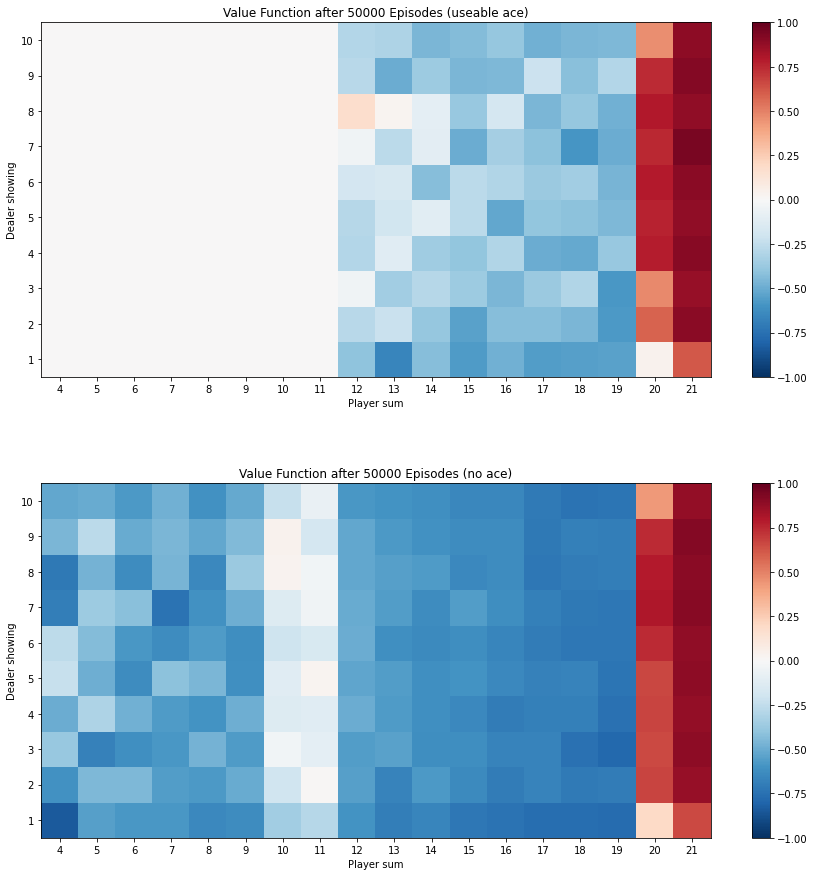

In [20]:
num_episodes = 50000

# let's create the example policy
policy = blackjack_example_policy()

# and now let's see how good our policy is
policy_value = mc_policy_evaluation(blackjack_env, policy, num_episodes=num_episodes)

# this plots a graphical representation of the value function
blackjack_plot_value_function(policy_value, title="Value Function after {} Episodes".format(num_episodes))

## Monte Carlo Control
We will now implement the on-policy, every-visit MC control algorithm for ε-soft policies.

In [21]:
def mc_control_epsilon_greedy(env, num_episodes=100, gamma=0.999, epsilon=0.5):
    """
    On-policy every-visit MC control algorithm for ε-soft policies
    Computes an optimal epsilon-greedy policy.
    
    Args:
        env: the openai gym environment
        num_episodes: number of episodes to sample
        gamma: the discount factor
        epsilon: chance to sample a random action
    
    Returns:
        a tuple (policy, Q)
        policy is a dict containing an epsilon greedy policy
        Q is a dict containing the state-action values
"""
    # get a good PRNG
    rng = np.random.default_rng()

    # keeps track of sum and count of returns for each state
    # to calculate an average.
    returns_sum = defaultdict(lambda: 0.)
    returns_count = defaultdict(lambda: 0.)
    
    # The action-value function estimate Q is a dictionary that holds arrays with action-values:
    # A nested dictionary that maps state -> (action -> action-value)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    actions = np.arange(env.action_space.n)
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes))

        # generate an episode:
        # an episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        while(True):
            probs = eps_greedy_from_qs(rng, Q[state], epsilon)
            action = rng.choice(actions, p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # loop over all (state, action) pairs that we've visited in this episode
        T = len(episode)
        # this loops over T-1, T-2, ..., 0
        G = 0
        for t in range(T-1, -1, -1):
            # reward is always from the transition from s via a to s' (r_{t+1} in the algorithm in the book)
            s, a, r = episode[t]
            G = gamma * G + r
            
            # we convert each state to a tuple so that we can use it as a dict key
            s_a = (s, a)
            returns_sum[s_a] += G
            returns_count[s_a] += 1.
            Q[s][a] = returns_sum[s_a] / returns_count[s_a]
    
    # after this call, there might be states missing, as not all were explored:
    possibly_incomplete_policy = eps_greedy_from_Q(rng, Q, epsilon)
    
    # if we have not encountered a state yet, behave randomly
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # fill in what we know from the possibly incomplete policy:
    policy.update(possibly_incomplete_policy)
    return policy, Q

### Run MC Control for Black Jack
Finally, let's compute a better policy for the Black Jack game. One hint: the results may differ slightly from the lecture slides. They will also be different from the optimal policies in the book, as the ones in the book were computed with 'Exploring Starts'. Do not worry too much about it, but you can always try with a few more samples...

Episode 10000/50000.
Episode 20000/50000.
Episode 30000/50000.
Episode 40000/50000.
Episode 50000/50000.
Episode 10000/50000.
Episode 20000/50000.
Episode 30000/50000.
Episode 40000/50000.
Episode 50000/50000.


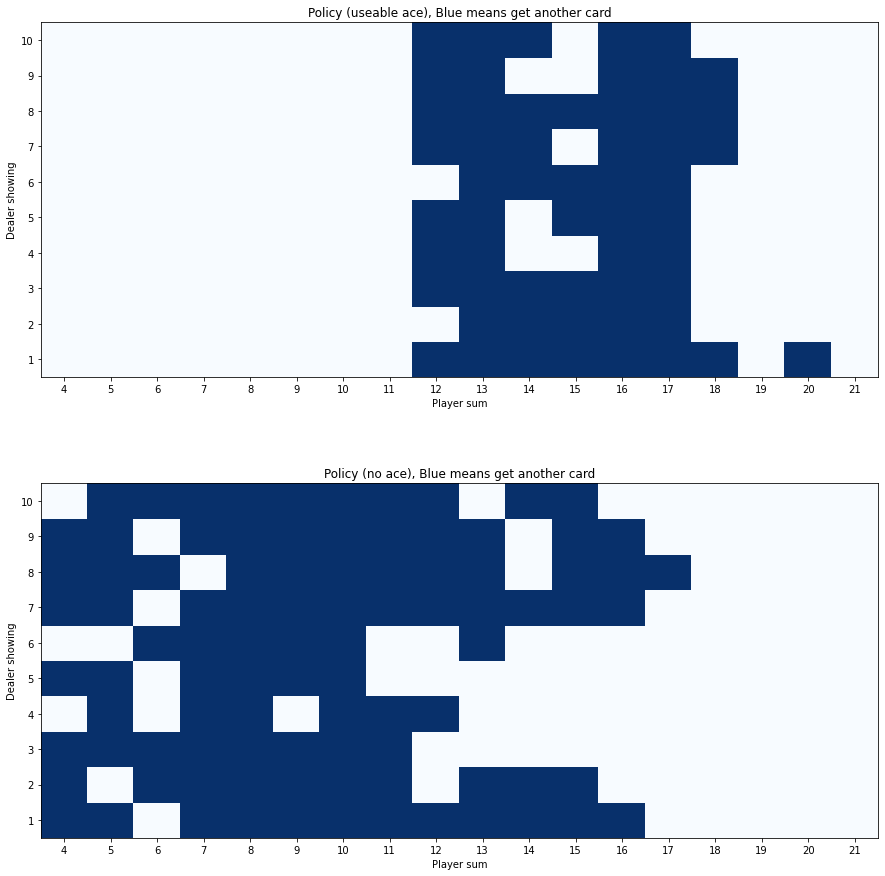

<Figure size 432x288 with 0 Axes>

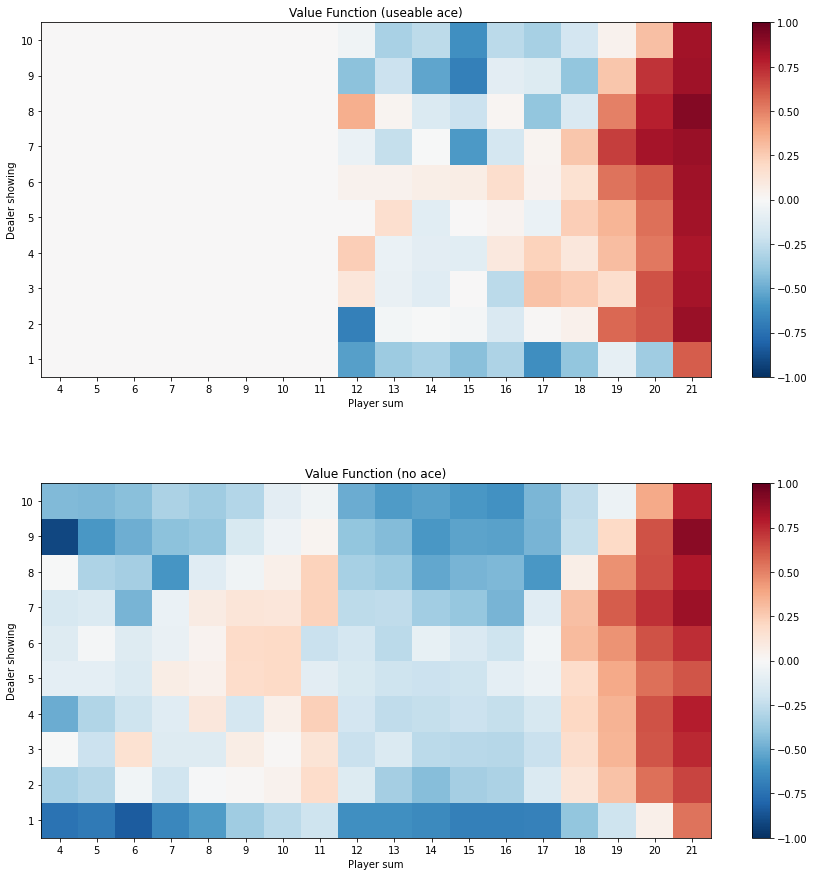

In [22]:
num_episodes = 50000  # set this to 10 ** 5 to get close to a nice policy
gamma = 0.999

# and now run our MC control algorithm
policy, Q = mc_control_epsilon_greedy(blackjack_env, num_episodes=num_episodes, gamma=gamma, epsilon=0.1)

# determine how good our policy is
policy_value = mc_policy_evaluation(blackjack_env, policy, num_episodes=num_episodes, gamma=gamma)

# plot the policy
blackjack_plot_policy(policy)

# and its associated value function
blackjack_plot_value_function(policy_value)

# Part 3: Frozen Lake Revisited (with Monte Carlo)
We will now go back to the Frozen Lake and run the MC algorithms on this problem. To do so, we need a few convenience function for converting the evaluation function and policy (a dict in the MC algorithms) to arrays, for outputting the data in the same way as with DP.

Spoiler Alert: These experiments will be a bit disappointing... but for some reasons MC does not work well on this problem instance. Why? (You will have to answer this question soon...)

Thus, we will use a smaller version of the frozen lake:

<pre><code>
SFFF
FHFH
FFFH
HFFG
</code>
</pre>

All the rules stay the same.

## Run MC Evaluation on the Frozen Lake (small)

### MC Evaluation on the Small Lake


SFFF
FHFH
FFFH
HFFG

The Value Function of the random policy, according to MC:

[[0.0144 0.0122 0.0152 0.    ]
 [0.0126 0.     0.0275 0.    ]
 [0.0211 0.0835 0.1205 0.    ]
 [0.     0.1522 0.4897 0.    ]]


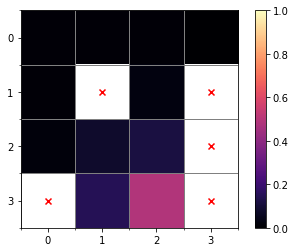


The Value Function of the random policy, according to DP:

[[0.0138 0.0115 0.0208 0.0104]
 [0.0161 0.     0.0406 0.    ]
 [0.0346 0.0878 0.1416 0.    ]
 [0.     0.1753 0.4387 0.    ]]


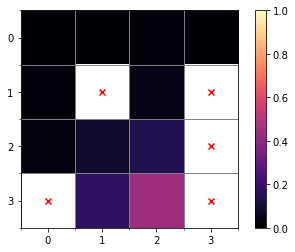

In [23]:
num_episodes = 1000  # set this to 50000 for better approximation

# we start with the smaller lake
small_lake_env = gym.make('FrozenLake-v0')
small_lake_env.reset()
small_lake_env.render()

# let's create a random policy
policy = gridworld_random_policy(small_lake_env)

# and now let's see how good our policy is
V_dict = mc_policy_evaluation(small_lake_env, policy, num_episodes, gamma=0.999)

# print the value function
print("\nThe Value Function of the random policy, according to MC:\n")
gridworld_print_value_function(small_lake_env, V_dict)
gridworld_plot_value_function(small_lake_env, V_dict, 0, 1)

# what does DP have to say about this small problem?
V_init = gridworld_initial_value_function(small_lake_env)
V_dict = dp_policy_evaluation(small_lake_env, policy, V_init, gamma=0.999)
print("\nThe Value Function of the random policy, according to DP:\n")
gridworld_print_value_function(small_lake_env, V_dict)
gridworld_plot_value_function(small_lake_env, V_dict, 0, 1)

### MC Evaluation on the Larger Lake


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

The Value Function of our Policy, according to MC:

[[0.0031 0.0022 0.0034 0.007  0.0107 0.0081 0.0136 0.0069]
 [0.0018 0.0017 0.0026 0.0036 0.0061 0.0172 0.037  0.037 ]
 [0.0024 0.0033 0.0011 0.     0.0054 0.0057 0.0194 0.0375]
 [0.0017 0.0033 0.0018 0.0066 0.0234 0.     0.0224 0.0843]
 [0.0015 0.0041 0.     0.     0.0284 0.0498 0.     0.083 ]
 [0.     0.     0.     0.     0.     0.0906 0.     0.19  ]
 [0.     0.     0.     0.     0.     0.2495 0.     0.6356]
 [0.     0.     0.     0.     0.     0.999  1.     0.    ]]


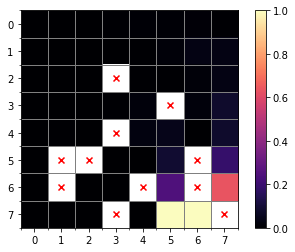


The Value Function of our Policy, according to DP:

[[0.0018 0.002  0.0027 0.0039 0.0063 0.0095 0.013  0.0155]
 [0.0015 0.0017 0.002  0.0029 0.0055 0.0091 0.0142 0.018 ]
 [0.0011 0.0011 0.001  0.     0.0038 0.0074 0.0166 0.0245]
 [0.0008 0.0007 0.0007 0.0008 0.0023 0.     0.0203 0.0389]
 [0.0004 0.0004 0.0003 0.     0.0048 0.0115 0.026  0.0721]
 [0.0002 0.     0.     0.0014 0.0054 0.0152 0.     0.1517]
 [0.0001 0.     0.0001 0.0004 0.     0.0441 0.     0.3837]
 [0.0001 0.     0.     0.     0.0537 0.1614 0.3869 0.    ]]


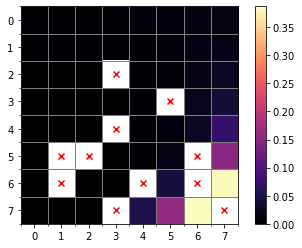

In [24]:
num_episodes = 1000  # set this to 500000 to see a better approximation

# well then, let's see what happens when we apply this method to the larger version:
larger_lake_env = gym.make('FrozenLake8x8-v0')
larger_lake_env.reset()
larger_lake_env.render()

# let's create a random policy
policy = gridworld_random_policy(larger_lake_env)

# and now let's see how good our policy is
V = mc_policy_evaluation(larger_lake_env, policy, num_episodes, gamma=0.999)

# print the value function
print("\nThe Value Function of our Policy, according to MC:\n")
gridworld_print_value_function(larger_lake_env, V)
gridworld_plot_value_function(larger_lake_env, V)

# what does DP have to say about this small problem?
V_init = gridworld_initial_value_function(larger_lake_env)
V = dp_policy_evaluation(larger_lake_env, policy, V_init, gamma=0.999)
print("\nThe Value Function of our Policy, according to DP:\n")
gridworld_print_value_function(larger_lake_env, V)
gridworld_plot_value_function(larger_lake_env, V)

## Run MC Control on the Frozen Lake

### MC Control on the Small Lake


SFFF
FHFH
FFFH
HFFG

The policy computed by MC:

[['R' 'D' 'R' 'U']
 ['D' 'H' 'L' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'R' 'G']]


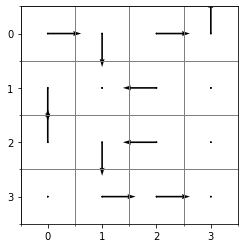


The value function of the MC policy:

[[0.1144 0.0945 0.1794 0.1386]
 [0.1312 0.     0.1718 0.    ]
 [0.2354 0.3381 0.3349 0.    ]
 [0.     0.4491 0.6225 0.    ]]


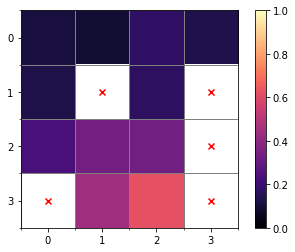

In [25]:
num_episodes = 1000  # set this to 100000 to see better policies

# we start with the smaller lake
small_lake_env = gym.make('FrozenLake-v0')
small_lake_env.reset()
small_lake_env.render()

# try MC control and evaluation
opt_policy_mc, Q_mc = mc_control_epsilon_greedy(small_lake_env, num_episodes, gamma=0.999, epsilon=0.1)

V_mc = mc_policy_evaluation(small_lake_env, opt_policy_mc, num_episodes)

print("\nThe policy computed by MC:\n")
gridworld_print_deterministic_policy(small_lake_env, opt_policy_mc)
gridworld_plot_policy(small_lake_env, opt_policy_mc)

print("\nThe value function of the MC policy:\n")
gridworld_print_value_function(small_lake_env, V_mc)
gridworld_plot_value_function(small_lake_env, V_mc, 0, 1)

### Contrast this with the result of DP control


Policy computed via the value iteration algorithm:

[['L' 'U' 'U' 'U']
 ['L' 'H' 'L' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'D' 'G']]


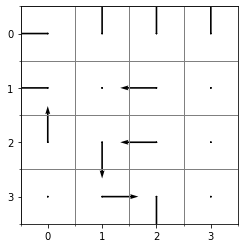


and the respective value function:

[[0.7855 0.7785 0.7739 0.7716]
 [0.7879 0.     0.5057 0.    ]
 [0.7926 0.7997 0.7448 0.    ]
 [0.     0.8641 0.9312 0.    ]]


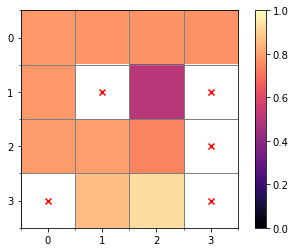

In [26]:
# compare and contrast this to DP control and evaluation
V_init = gridworld_initial_value_function(small_lake_env)
opt_policy_dp, V_dp = dp_value_iteration(small_lake_env, V_init, gamma=0.999)

print("\nPolicy computed via the value iteration algorithm:\n")
gridworld_print_deterministic_policy(small_lake_env, opt_policy_dp)
gridworld_plot_policy(small_lake_env, opt_policy_dp)

print("\nand the respective value function:\n")
gridworld_print_value_function(small_lake_env, V_dp)
gridworld_plot_value_function(small_lake_env, V_dp, 0, 1)

### MC Control on the Larger Lake


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

The computed Policy:

[['D' 'R' 'R' 'R' 'U' 'U' 'L' 'U']
 ['D' 'R' 'D' 'D' 'D' 'L' 'R' 'L']
 ['U' 'R' 'U' 'H' 'U' 'R' 'U' 'U']
 ['R' 'R' 'U' 'D' 'L' 'H' 'U' 'L']
 ['D' 'L' 'L' 'H' 'D' 'U' 'D' 'R']
 ['D' 'H' 'H' 'D' 'L' 'R' 'H' 'D']
 ['D' 'H' 'D' 'L' 'H' 'U' 'H' 'D']
 ['R' 'R' 'U' 'H' 'L' 'L' 'L' 'G']]


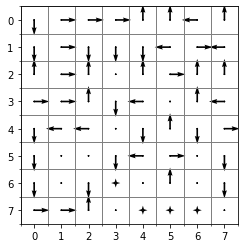


The Value Function of our Policy, according to MC:

[[0.0031 0.0042 0.0064 0.0081 0.0076 0.0106 0.0157 0.0083]
 [0.006  0.0045 0.0061 0.0042 0.0061 0.0101 0.0336 0.0245]
 [0.0034 0.0015 0.0027 0.     0.0059 0.0088 0.0263 0.0336]
 [0.     0.     0.     0.     0.     0.     0.0451 0.1555]
 [0.     0.     0.     0.     0.     0.     0.     0.2848]
 [0.     0.     0.     0.     0.     0.     0.     0.3841]
 [0.     0.     0.     0.     0.     0.     0.     0.7141]
 [0.     0.     0.     0.     0.     0.     0.     0.    ]]


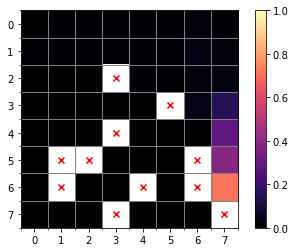


Policy computed via the value iteration algorithm:

[['U' 'R' 'R' 'R' 'R' 'R' 'R' 'R']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'R']
 ['L' 'U' 'L' 'H' 'R' 'U' 'R' 'R']
 ['L' 'L' 'L' 'D' 'L' 'H' 'R' 'R']
 ['L' 'U' 'L' 'H' 'R' 'D' 'U' 'R']
 ['L' 'H' 'H' 'D' 'U' 'L' 'H' 'R']
 ['L' 'H' 'D' 'L' 'H' 'L' 'H' 'R']
 ['L' 'D' 'L' 'H' 'D' 'R' 'D' 'G']]


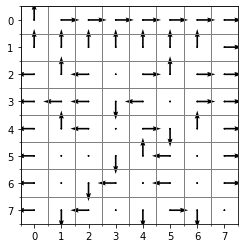


and the respective value function:

[[0.8926 0.8953 0.8993 0.9039 0.9087 0.9138 0.9186 0.9224]
 [0.892  0.894  0.8974 0.9017 0.9065 0.9117 0.9176 0.9252]
 [0.8766 0.8623 0.8188 0.     0.7777 0.8653 0.909  0.9307]
 [0.8638 0.8115 0.6993 0.4206 0.5637 0.     0.8816 0.939 ]
 [0.8537 0.7109 0.4696 0.     0.4946 0.5684 0.7992 0.9502]
 [0.8461 0.     0.     0.1527 0.3531 0.413  0.     0.9642]
 [0.841  0.     0.1642 0.1055 0.     0.3188 0.     0.9811]
 [0.8385 0.6121 0.3876 0.     0.2718 0.5443 0.7715 0.    ]]


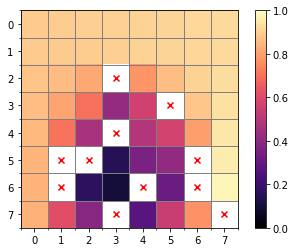

In [27]:
# and now for the bigger problem instance...
larger_lake_env = gym.make('FrozenLake8x8-v0')
larger_lake_env.reset()
larger_lake_env.render()

num_episodes = 1000  # set this to 10 ** 6 to see better policies

# let's create a random policy
policy, Q = mc_control_epsilon_greedy(larger_lake_env, num_episodes, gamma=0.999, epsilon=0.2)

print("\nThe computed Policy:\n")
gridworld_print_deterministic_policy(larger_lake_env, policy)
gridworld_plot_policy(larger_lake_env, policy)

# and now let's see how good our policy is
V = mc_policy_evaluation(larger_lake_env, policy, num_episodes, gamma=0.999)

# print the value function
print("\nThe Value Function of our Policy, according to MC:\n")
gridworld_print_value_function(larger_lake_env, V)
gridworld_plot_value_function(larger_lake_env, V, 0, 1)

# let's compare this to DP...
V_init = gridworld_initial_value_function(larger_lake_env)
policy, V = dp_value_iteration(larger_lake_env, V_init, gamma=0.999)

print("\nPolicy computed via the value iteration algorithm:\n")
gridworld_print_deterministic_policy(larger_lake_env, policy)
gridworld_plot_policy(larger_lake_env, policy)

print("\nand the respective value function:\n")
gridworld_print_value_function(larger_lake_env, V)
gridworld_plot_value_function(larger_lake_env, V, 0, 1)

## (3.1) Analysis of DP and MC on the Frozen Lake (2 points)

Compare DP and MC on the frozen lake problem. Why is MC not working well?

It can be observed that MC does not perform or work well on the lake problem as it seems to be stuck in a loop. This is due the value function of the policy, as MC involve samples to update where DP updates involve estimates that use previous estimates. This is why we can see that the MC performes poorly.

# (4) Temporal Difference Learning
You will need to implement evaluation and control algorithms. We will use a package 'gym_gridworlds' here, containing a few extra environments. The directory 'gym_gridworlds' should be a subdirectory of the folder that you started the Jupyter notebook server in.

In [28]:
import gym_gridworlds
np.set_printoptions(linewidth=200)

## (4.1) TD(0) policy evaluation
Your first task is to implement the TD(0) policy evaluation algorithm.

In [29]:
def td_policy_evaluation(env, policy, num_episodes, gamma=0.999, alpha=0.1, schedule=False):
    V = defaultdict(lambda: 0)
    # TODO
    for i_episode in range(1, num_episodes + 1):
    # print out which episode we're on, useful for debugging.
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes))
        episode = []
        state = env.reset()
        actions = np.arange(env.action_space.n)
        while(True):
            # sample from the policy:
            # sample from a discrete distribution, with probabilities 'p' given by the policy
            action = rng.choice(actions, p=policy[state])
            next_state, reward, done, _ = env.step(action)
            v = V[state]
            v_t1 = V[next_state]
            V[state] += alpha * (reward + gamma * v_t1 - v)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
    return V

### Now let's try TD(0) to evaluate the random policy


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG
Episode 100/1000.
Episode 200/1000.
Episode 300/1000.
Episode 400/1000.
Episode 500/1000.
Episode 600/1000.
Episode 700/1000.
Episode 800/1000.
Episode 900/1000.
Episode 1000/1000.


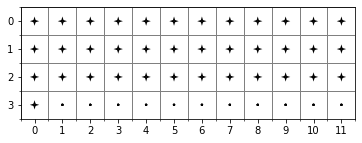

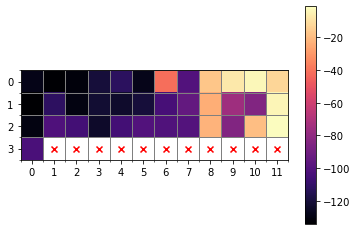

In [30]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 1000
alpha = 0.9
gamma = 0.999
epsilon = 0.1

policy = gridworld_random_policy(cliff_env)
V = td_policy_evaluation(cliff_env, policy, num_episodes, gamma=gamma, alpha=alpha)

gridworld_plot_policy(cliff_env, policy)
gridworld_plot_value_function(cliff_env, V, vmax=-1)

## (4.2) SARSA (5 Points)
Your task is to implement SARSA, and test it on the Cliff environment.

In [31]:
def epsilon_greedy(Q, epsilon, n_actions, s):

    if np.random.random() < epsilon: 
        action = np.random.randint(n_actions) 
    else: 
        action = np.argmax(Q[s])
    return action

def sarsa(env, num_episodes, gamma, alpha, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    n_states, n_actions = env.observation_space.n, env.action_space.n
    for i_episode in range(1,num_episodes+1):
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes))
        s = env.reset()
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        while True:
            s_, reward, done, info = env.step(a)
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            Q[s][a] += alpha * (reward + (gamma * Q[s_][a_]) - Q[s][a] )
            s, a = s_, a_
            if done:
                break
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q

### Setup Environment

In [32]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 1000
alpha = 0.9
gamma = 0.95
epsilon = 0.1


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


### Run Algorithm



------------------------------
SARSA
num_episodes 1000
alpha 0.9
gamma 0.95
Episode 100/1000.
Episode 200/1000.
Episode 300/1000.
Episode 400/1000.
Episode 500/1000.
Episode 600/1000.
Episode 700/1000.
Episode 800/1000.
Episode 900/1000.
Episode 1000/1000.
[['R' 'R' 'D' 'R' 'L' 'R' 'R' 'D' 'R' 'R' 'D' 'D']
 ['D' 'R' 'L' 'R' 'R' 'U' 'U' 'R' 'R' 'R' 'R' 'D']
 ['D' 'L' 'R' 'L' 'U' 'U' 'U' 'U' 'U' 'R' 'R' 'D']
 ['U' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'G']]


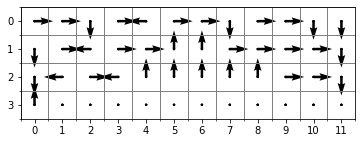

[[-20.     -20.     -20.     -20.     -20.      -7.395   -6.7316  -6.0333  -5.2982  -4.5244  -3.7099  -2.8525]
 [-20.     -20.     -20.      -9.1928  -8.624   -8.0253  -7.395   -5.2982  -4.5244  -3.7099  -2.8525  -1.95  ]
 [-20.     -20.     -20.     -20.      -9.1928  -8.624   -8.0253  -6.0333  -5.2982  -2.8525  -1.95    -1.    ]
 [-20.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.    ]]


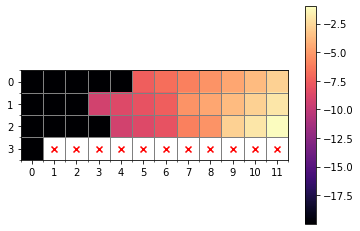

In [33]:
print('\n\n' + '-' * 30)
print('SARSA')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)
policy, Q = sarsa(cliff_env, num_episodes, gamma=gamma, alpha=alpha, epsilon=epsilon)

V_init = gridworld_initial_value_function(cliff_env)
V = dp_policy_evaluation(cliff_env, policy, V_init, gamma=gamma)

gridworld_print_deterministic_policy(cliff_env, policy)
gridworld_plot_policy(cliff_env, policy)

gridworld_print_value_function(cliff_env, V)
gridworld_plot_value_function(cliff_env, V, vmax=-1)

## (4.3) Q-Learning (5 Points)
Your task is to implement Q-Learning, and test it on the Cliff environment.

In [34]:
def q_learning(env, num_episodes, gamma, alpha, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    n_states, n_actions = env.observation_space.n, env.action_space.n
    for i_episode in range(1,num_episodes+1):
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes))
        s = env.reset()
        while True:
            a = epsilon_greedy(Q, epsilon, n_actions, s)
            s_, reward, done, info = env.step(a)
            Q[s][a] += alpha * (reward + gamma * np.max(Q[s_]) - Q[s][a])
            s,a = s_,a
            if done:
                break
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q

### Setup Environment

In [35]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 1000
alpha = 0.9
gamma = 0.95
epsilon = 0.1


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


### Run Algorithm



------------------------------
Q-Learning
num_episodes 1000
alpha 0.9
gamma 0.95
Episode 100/1000.
Episode 200/1000.
Episode 300/1000.
Episode 400/1000.
Episode 500/1000.
Episode 600/1000.
Episode 700/1000.
Episode 800/1000.
Episode 900/1000.
Episode 1000/1000.
[['R' 'R' 'D' 'R' 'U' 'D' 'R' 'R' 'R' 'R' 'R' 'D']
 ['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'G']]


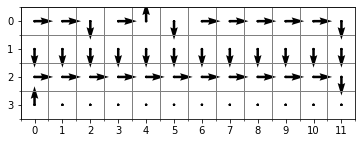

[[-10.2465  -9.7332  -9.1928 -20.     -20.      -7.395   -6.7316  -6.0333  -5.2982  -4.5244  -3.7099  -2.8525]
 [ -9.7332  -9.1928  -8.624   -8.0253  -7.395   -6.7316  -6.0333  -5.2982  -4.5244  -3.7099  -2.8525  -1.95  ]
 [ -9.1928  -8.624   -8.0253  -7.395   -6.7316  -6.0333  -5.2982  -4.5244  -3.7099  -2.8525  -1.95    -1.    ]
 [ -9.7332   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.    ]]


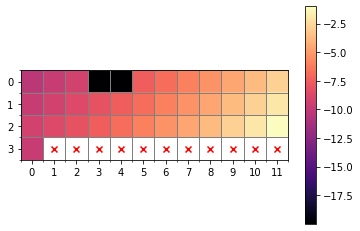

In [36]:
print('\n\n' + '-' * 30)
print('Q-Learning')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)
policy, Q = q_learning(cliff_env, num_episodes, gamma=gamma, alpha=alpha, epsilon=epsilon)
V_init = gridworld_initial_value_function(cliff_env)
V = dp_policy_evaluation(cliff_env, policy, V_init, gamma=gamma)

gridworld_print_deterministic_policy(cliff_env, policy)
gridworld_plot_policy(cliff_env, policy)

gridworld_print_value_function(cliff_env, V)
gridworld_plot_value_function(cliff_env, V, vmax=-1)

## (4.4) Expected SARSA (5 Points)

In [37]:
def expected_sarsa(env, num_episodes, gamma, alpha, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    n_states, n_actions = env.observation_space.n, env.action_space.n
    for i_episode in range(1,num_episodes+1):
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes))
        s = env.reset()
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        while True:
            s_, reward, done, info = env.step(a)
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            Q[s][a] += alpha * (reward + (gamma * np.mean(Q[s_])) - Q[s][a])
            s,a = s_,a_
            if done:
                break
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q

### Setup Environment

In [38]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 1000
alpha = 0.9
gamma = 0.95
epsilon = 0.1


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


### Run Algorithm



------------------------------
Expected SARSA
num_episodes 1000
alpha 0.9
gamma 0.95
Episode 100/1000.
Episode 200/1000.
Episode 300/1000.
Episode 400/1000.
Episode 500/1000.
Episode 600/1000.
Episode 700/1000.
Episode 800/1000.
Episode 900/1000.
Episode 1000/1000.
[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'U' 'R' 'U' 'U' 'U' 'U' 'U' 'R' 'U' 'R' 'D']
 ['U' 'U' 'U' 'U' 'U' 'R' 'U' 'L' 'R' 'U' 'R' 'D']
 ['U' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'G']]


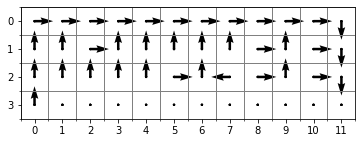

[[-10.2465  -9.7332  -9.1928  -8.624   -8.0253  -7.395   -6.7316  -6.0333  -5.2982  -4.5244  -3.7099  -2.8525]
 [-10.7342 -10.2465  -9.7332  -9.1928  -8.624   -8.0253  -7.395   -6.7316  -6.0333  -5.2982  -2.8525  -1.95  ]
 [-11.1975 -10.7342 -10.2465  -9.7332  -9.1928  -8.624   -8.0253  -8.624   -6.7316  -6.0333  -1.95    -1.    ]
 [-11.6376   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.    ]]


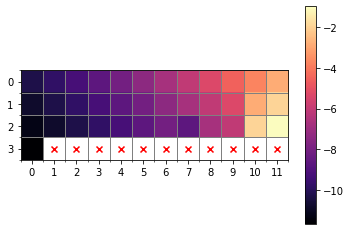

In [39]:
print('\n\n' + '-' * 30)
print('Expected SARSA')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)
policy, Q = expected_sarsa(cliff_env, num_episodes, gamma=gamma, alpha=alpha, epsilon=epsilon)
V_init = gridworld_initial_value_function(cliff_env)
V = dp_policy_evaluation(cliff_env, policy, V_init, gamma=gamma)

gridworld_print_deterministic_policy(cliff_env, policy)
gridworld_plot_policy(cliff_env, policy)

gridworld_print_value_function(cliff_env, V)
gridworld_plot_value_function(cliff_env, V, vmax=-1)

### Let's compare this to DP Value Iteration



------------------------------
DP Value Iteration
[['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']
 ['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'G']]


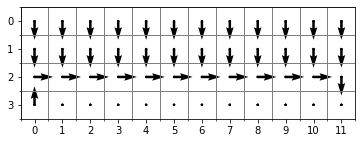

[[-10.2465  -9.7332  -9.1928  -8.624   -8.0253  -7.395   -6.7316  -6.0333  -5.2982  -4.5244  -3.7099  -2.8525]
 [ -9.7332  -9.1928  -8.624   -8.0253  -7.395   -6.7316  -6.0333  -5.2982  -4.5244  -3.7099  -2.8525  -1.95  ]
 [ -9.1928  -8.624   -8.0253  -7.395   -6.7316  -6.0333  -5.2982  -4.5244  -3.7099  -2.8525  -1.95    -1.    ]
 [ -9.7332   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.    ]]


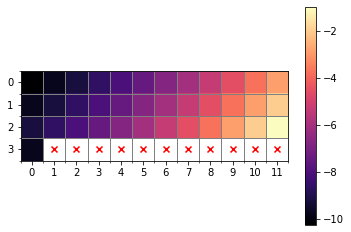

In [40]:
print('\n\n' + '-' * 30)
print('DP Value Iteration')
V_init = gridworld_initial_value_function(cliff_env)
policy, V = dp_value_iteration(cliff_env, V_init, gamma=gamma)
V = dp_policy_evaluation(cliff_env, policy, V_init, gamma=gamma)

gridworld_print_deterministic_policy(cliff_env, policy)
gridworld_plot_policy(cliff_env, policy)

gridworld_print_value_function(cliff_env, V)
gridworld_plot_value_function(cliff_env, V, vmax=-1)

## (4.5) Double Q-Learning (5 Points)

Let's try to recreate an approximation to the figure 2 from [this paper](https://proceedings.neurips.cc/paper/2010/file/091d584fced301b442654dd8c23b3fc9-Paper.pdf), where Double-Q learning is put to the test.

We will only try to approximately recreate this, as unfortunately the OpenAI-gym environments and the PRNG methods of numpy are way too slow to get the same figure.

In [41]:

def double_q_paper(env, num_episodes, gamma=0.95, alpha=None, double_flag=True):
    if double_flag:
        # if double-q learning is switched ON, we use two
        # tables to approximate the q-function
        QX = defaultdict(lambda: np.zeros(env.action_space.n))
        QY = defaultdict(lambda: np.zeros(env.action_space.n))
    else:
        # if it is switched OFF, both these tables are the same
        QX = QY = defaultdict(lambda: np.zeros(env.action_space.n))

    # HINTS:
    # 1) this is to count the number of visits per state (per episode!)
    # increment with N[s] += 1 where appropriate
    N = defaultdict(lambda: 0)
    
    # 2) this is to count the number of visits per state-action pair (per episode!)
    # increment with NT[s, a] += 1 where appropriate
    NT = defaultdict(lambda: 0)

    # 3) to derive an epsilon greedy policy, use:
    #epsilon = 1. / np.sqrt(N[s])
    
    # 4) the epsilon greedy policy for behavior should be derived from
    #qs = (QX[s] + QY[s]) / 2.
    
    # 5) to get the learning rate for an update use
    #alpha(NT[s, a])
    
    
    for i_episode in range(1,num_episodes+1):
        s = env.reset()
        N[s]+=1
        while True:
            rand = np.random.random()
            Q = QX[s]+QY[s]
            if N[s]==0:
                N[s]=1
            epsilon = 1. / np.sqrt(N[s])
            if np.random.random() < epsilon:
                a = env.action_space.sample()
            else:
                q_table = QX[s]+QY[s]
                a = np.argmax(q_table)
            NT[s, a] += 1
            alph = alpha(NT[s, a])
            s_, reward, done, info = env.step(a)
            if rand <= 0.5:
                a_ = np.argmax(QX[s_])
                QX[s][a] = QX[s][a] + alph*(reward + gamma*QY[s_][a_] - QX[s][a])
            elif rand > 0.5:
                a_ = np.argmax(QY[s_])
                QY[s][a] = QY[s][a] + alph*(reward + gamma*QX[s_][a_] - QY[s][a])
            s=s_
            if done:
                break
            
    ######################################################################################
    # don't change the following

    # sum up Q values of both estimates QX, QY
    Q = dict()
    for s in range(env.observation_space.n):
        Q[s] = (QX[s] + QY[s]) / 2.
    
    # after this call, there might be states missing from policy, as exploration
    # could have missed some states. so if we have not encountered a state yet, behave randomly
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q


### Setup Environment

In [42]:
import gym_gridworlds

bd_env = gym.make('QBiasTest-v0')
bd_env.reset()
bd_env.render()


FFG
FFF
SFF


### Let's try an example first:

Average per-step rewards (Q-Learning):
-0.7759607859290687
Policy obtained via Q-Learning


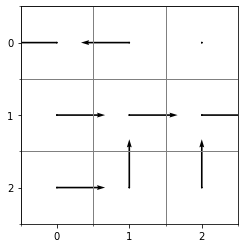

Average per-step rewards (Double Q-Learning):
-0.8225312826870181
Policy obtained via Double Q-Learning


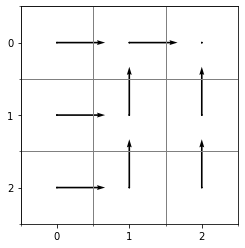

In [43]:
gamma = 0.95  # from the paper
num_episodes = 1000  # a low number, to see results quickly

# the linear learnrate schedule
linear_alpha = lambda nsa: 1. / nsa

# the polynomial learnrate schedule
poly_alpha = lambda nsa: 1. / (nsa ** 0.8)

# to recreate the figure, we have to log all per-step rewards
# this particular environment has a method to reset the log 
bd_env.reset_rewards()

# let's run the algorithm with double-q switched OFF
ql_policy, ql_Q = double_q_paper(bd_env, num_episodes, gamma=gamma, alpha=poly_alpha, double_flag=False)

# and to retrieve the log of rewards
print('Average per-step rewards (Q-Learning):')
print(np.mean(bd_env.get_rewards()))

print('Policy obtained via Q-Learning')
gridworld_plot_policy(bd_env, ql_policy)

bd_env.reset_rewards()
# and now let's run the algorithm with double-q switched ON 
dq_policy, dq_Q = double_q_paper(bd_env, num_episodes, gamma=gamma, alpha=poly_alpha, double_flag=True)

print('Average per-step rewards (Double Q-Learning):')
print(np.mean(bd_env.get_rewards()))

print('Policy obtained via Double Q-Learning')
gridworld_plot_policy(bd_env, dq_policy)

### Let's compare that to DP Value Iteration

Policy obtained via Value Iteration:


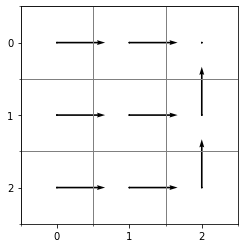

In [44]:
print('Policy obtained via Value Iteration:')
V_init = gridworld_initial_value_function(bd_env)
dp_policy, V = dp_value_iteration(bd_env, V_init, gamma=gamma)

gridworld_plot_policy(bd_env, dp_policy)

### And now for an approximation of the figure in the paper:
First, we'll define the function that runs an algorithm configuration.

In [45]:
# this conducts the experiment for an algorithm configuration, and returns the results
# we start at num_episodes = 'start',
# advance in steps of 'step',
# and end at 'end'
# for each value of 'num_episodes', we'll compute 'n_samples' samples
def biasdemo_run_experiment(algorithm, start, end, step, n_samples):
    all_max_q_for_start = []
    all_avg_rewards = []
    bd_env = gym.make('QBiasTest-v0')

    for num_episodes in range(start, end, step):
        print(f'gathering {n_samples} samples for {num_episodes} num_episodes')
        max_q_for_start = []
        avg_rewards = []
        for run in range(n_samples):
            bd_env.reset_rewards()
            policy, Q = algorithm(bd_env, num_episodes, gamma=0.95)
            
            max_q_for_start.append(np.max(Q[bd_env.get_start()]))
            
            avg_reward = np.mean(bd_env.get_rewards())
            avg_rewards.append(avg_reward)

        avg_rewards_percentiles = np.percentile(avg_rewards, [10, 50, 90]).tolist()
        max_q_for_start_percentiles = np.percentile(max_q_for_start, [10, 50, 90]).tolist()
        
        all_avg_rewards.append([num_episodes] + avg_rewards_percentiles)
        all_max_q_for_start.append([num_episodes] + max_q_for_start_percentiles)

    all_max_q_for_start = np.array(all_max_q_for_start)
    all_avg_rewards = np.array(all_avg_rewards)
    return all_max_q_for_start, all_avg_rewards

### Running the computational experiment
We will now define the plotting code, the algorithm configurations, and run the experiments.

running configuration with schedule: linear and Q-Learning
gathering 3 samples for 10 num_episodes
gathering 3 samples for 20 num_episodes
gathering 3 samples for 30 num_episodes
gathering 3 samples for 40 num_episodes
gathering 3 samples for 50 num_episodes
gathering 3 samples for 60 num_episodes
gathering 3 samples for 70 num_episodes
gathering 3 samples for 80 num_episodes
gathering 3 samples for 90 num_episodes
running configuration with schedule: linear and Double Q-Learning
gathering 3 samples for 10 num_episodes
gathering 3 samples for 20 num_episodes
gathering 3 samples for 30 num_episodes
gathering 3 samples for 40 num_episodes
gathering 3 samples for 50 num_episodes
gathering 3 samples for 60 num_episodes
gathering 3 samples for 70 num_episodes
gathering 3 samples for 80 num_episodes
gathering 3 samples for 90 num_episodes
running configuration with schedule: poly and Q-Learning
gathering 3 samples for 10 num_episodes
gathering 3 samples for 20 num_episodes
gathering 3 sample

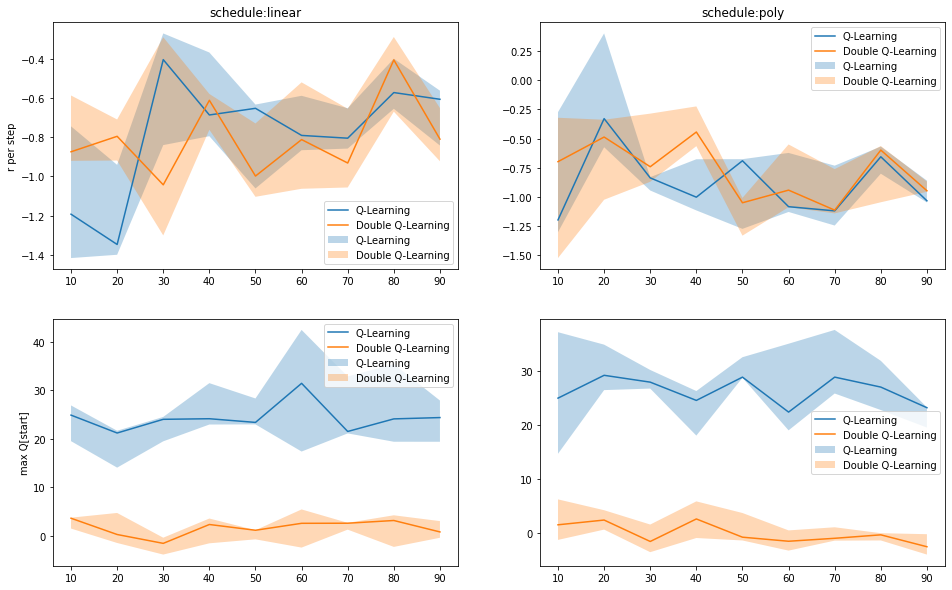

In [46]:
import matplotlib.pyplot as plt
from functools import partial

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

axes[0, 0].set_ylabel('r per step')
axes[1, 0].set_ylabel('max Q[start]')

NEP = 0
P10 = 1
P50 = 2
P90 = 3

# try all four combinations, as in the paper
for icol, lr_schedule_name, lr_schedule in [(0, 'linear', linear_alpha), (1, 'poly', poly_alpha)]:
    axes[0, icol].set_title(f'schedule:{lr_schedule_name}')
    
    for algo_name, double_flag in [('Q-Learning', False), ('Double Q-Learning', True)]:
        # we use partial functions to define algorithm configurations
        # think of a partial function as a function that has parameters filled in already
        # assume: f(a, b) is defined
        # fill in parameter 'a' of 'f': g = partial(f, a=0)
        # we can now use 'g(b)' as if we'd have written 'f(0, b)'
        
        # we use it here to define the learnrate schedule
        # and to set the flag that switches on double-q learning
        print(f'running configuration with schedule: {lr_schedule_name} and {algo_name}')
        algorithm_configuration = partial(double_q_paper, alpha=lr_schedule, double_flag=double_flag)
        max_q, avg_rewards = biasdemo_run_experiment(
            algorithm_configuration,
            start=10,
            end=100,
            step=10,
            n_samples=3
        )

        axes[0, icol].fill_between(
            avg_rewards[:, NEP],
            avg_rewards[:, P10],
            avg_rewards[:, P90],
            alpha=0.3,
            label=algo_name
        )
        axes[0, icol].plot(
            avg_rewards[:, NEP],
            avg_rewards[:, P50],
            label=algo_name
        )
        
        axes[1, icol].fill_between(
            max_q[:, NEP],
            max_q[:, P10],
            max_q[:, P90],
            alpha=0.3,
            label=algo_name
        )
        axes[1, icol].plot(
            max_q[:, NEP],
            max_q[:, P50],
            label=algo_name
        )

for ax in axes.flatten():
    ax.legend()
plt.show()      

### What it should look like
If you use `start=1000, end=10000, step=1000, n_samples=50` to run the above experiment, this will take a loooong time, but your result should look approximately like this:
![The Goal](reproduction_in_spirit.png)